# Naučno izračunavanje 
Nastavnik: dr. Nina Radojičić Matić  
Asistent: Anđelka Zečević  
Marko Spasić 1014/2020  
Projekat: https://github.com/spaske00/matf-ni-mi201014  

## Kmeans (naive)

```pseudo
KMeans
Ulaz: Skup tačaka X=[x0, x1, x2...Xn], xi iz R^m
Izlaz: Indeksi: I=[j0, j1, j2,...jn] gde je ji indeks klastera kome xi pripada

1. Nasumično odaberi C=[C0, C1, ...Ck] tacaka iz X kao centroide klastera
2. Svakoj tacki iz X dodeli indeks najblizeg centroida C
3. Azuriraj centroide Ci=avg(sve tacke iz X kojima je najblizi centroid Ci)
4. Ponavljaj 2-4 M iteracija ili uslova konvergencije

```


## 1.1 Tehnike optimizacije programa naučnog izračunavanja pisanih na niskom nivou u C++ jeziku na primeru KMeans algoritma

Rad na primeru algoritma KMeans demonstrira dole navedene tehnike efikasnog izračunavanja. Performanse implementacije sklearn biblioteke se koriste kao referentna vrednost. 

Rad sa brojevima u pokretnom zarezu:
- efikasne IO operacije
- parsiranje brojeva u pokrentom zarezu
- čuvanje i pristup u radnoj memoriji
- aritmetičke operacije (šta kompajler može da optimizuje)

Podela posla i paralelzacija:
- sekvencijalna implementacija
- paralelna implementacija sa aktivnim čekanjem
- paralelna implementacija sa tokom izvršavanja (taskflow)

Budući rad:
- implementirati i testirati OpenMP verziju paralelizma
- implementirati i testirati OpenCL verziju paralelizma
- 

## 1.2 IO operacije

Standarna biblioteka C++ za čitanje i pisanje datoteka definiše hijerarhiju klasa poznatu kao tokovi (strimovi). 
<img src='attachments/std-io-complete-inheritance.jpg'/>

Kod koji u datoteku data.csv 3 vrednosti u pokrentom zarezu razdvojene karakterom `,`:
[godbolt](https://godbolt.org/z/8TPP1zeeW)
```c++
void write_to_csv(float x, float y, float z) {
    std::ofstream out("data.csv");
    out << x << ',' << y << ',' << z << '\n';
}
```
Kompajler u ovom slučaju tretira izraz ``out << x << ',' << y << ',' << z << '\n';`` kao 6 poziva overlodovanoj funkciji operator<< za upis vrednosti u strim. Sa optimizacijama ``-O2`` g++-11 generiše sledeći asembler kod za x64 arhitekturu: [godbolt](https://godbolt.org/z/8TPP1zeeW)

Za velike skupove podataka gde je potrebno upisati/pročitati vrednosti u pokretnom zarezu reda 10^6 i više, sve dodatne opepracije značajno doprinose brzini izvršavanje IO operacija. Za poredjenje:
[godbolt](https://godbolt.org/z/vahYdx7er)
```c++
#include<cstdio>

void write_to_csv(float a, float b, float c) {
    FILE* f = fopen("data.csv", "w");
    fprintf(f, "%f, %f, %f", a, b, c);
}
``` 
Generiše: [godbolt](https://godbolt.org/z/vahYdx7er)


U ovom projektu je korišćena biblioteka [fast_io](https://github.com/tearosccebe/fast_io), koja je po benčmarkovima daleko efikasnija od standarne biblioteke C++ za rad sa ulazom i izlazom. 

### Platform 	Linux 	GCC 11.0.0 	glibc + libstdc++
			
|Method|Output time|Input time|Comment|
|---|---|---|---|
|stdio.h(fprintf/fscanf)|0.532792935s|0.591907111s||
|fstream with rdbuf.sputc trick|0.318896068s|0.429406415s||
|**fast_io::i/obuf_file**|0.050300857s|0.065372395s||
|**fast_io::i/obuf_file_mutex**|0.05290654s|0.083040518s|thread safe|
|c_locale_i/obuf_file ("C")|0.051939052s|0.065820056s|imbued with locale, locale "C"|
|c_locale_i/obuf_file local|0.162406082s|Meaningless|imbued with locale, locale ""|
|std::to_chars+obuf_file| 	0.115453587s| 	Meaningless 	|
|fmt::format_int+obuf_file| 	0.1183587s| 	Meaningless 	|
|fmt::format_int+ofstream| 	0.195914384s| 	Meaningless| 	
|fmt::format+ofstream| 	0.633590975s| 	Meaningless| 	fmt makes things slower|
|fmt::print| 	0.495270371s| 	Meaningless| 	fmt makes things slower|
|boost::iostreams| 	0.400906063s| 	0.444717051s| 	Using boost iostreams does not make your code faster|
|**fast_io::c_file_unlocked**| 	0.060076723s| 	0.073299716s| 	I hacked glibc's FILE* implementation|
|**fast_io::c_file**| 	0.092490191s| 	0.104545535s| 	Thread Safe. I hacked glibc's FILE* implementation|
|**fast_io::filebuf_file**| 	0.052251608s| 	0.06655806s| 	I hacked libstdc++'s streambuf/filebuf implementation|
*Tabela preuzta sa: https://github.com/tearosccebe/fast_io/blob/master/readme.md*

## 1.3 Parsiranje brojeva u pokretnom zarezu

Parsiranje brojeva u pokrentom zarezu je jedna od fundamentalnih operacija prilikom rada sa podacima. Zbog čestog korišćenja od izuzetne je važnosti da bude efikasna. Razvojem modernih arhitektura procesora na ovom polju je došlo do značajnog napretka radom profesora Daniel Lemire u radu [Number Parsing at a Gigabyte per Second](https://arxiv.org/pdf/2101.11408.pdf). 

|nstructions|mispredictions|cycles|instructions/cycle|
|---|---|---|---|
|netlib|740|4.1|330|2.2|
|double-conversion|1100|1.7|380|3.0|
|strtod|1100|0.7|370|3.0|
|abseil|600|0.5|160|3.8|
|ourparser|280|0.01|66|4.2|
||juststring)|215|0.00|46|4.7|
*tabela 10: https://arxiv.org/pdf/2101.11408.pdf*

U kombinaciji sa fast_io, i minimizovanjem broja alokacija, IO operacije nad csv datotekama su do 2x brže od numpy loadtxt i savetxt funkcija.

Razlike su veće na manjim skupovima podataka ( < 32000) do x6 puta, dok na većim podacima se razlike svode do 1.5x.

Biblioteka je jednostavna za korišćenje.

```c++
for (u64 i = 0; i < result.m_num_of_values; ++i) {
    assert(file_it != csv_file.end());
    auto from_chars_result = fast_float::from_chars(file_it, csv_file.cend(), result.m_data[i]);
    file_it = std::next(from_chars_result.ptr);
}
```
Prva dva parametra funkcije fast_float::from_chars su pokzivači na trenutu poziciju u baferu i kraj bafera.
Treći parametar je referenca na promenljivu u kojoj će parsirana vrednost biti sačuvana. 
Povratna vrednost funkcije je resultat koji ima pokazivač na mesto na kom se parsiranje završilo .ptr i indikator bool da li je parsiranje bilo uspešno.


## 1.4 Čuvanje i pristup podacima u radnoj memoriji

Moderne ahitekture procesora koriste **keš memoriju** kako bi ubrzle pristup podacima iz glavne memorije. Brzine keš memorije i uticaj na performanse variraju u zavisnosti od mikroarhitekture i proizvođača procesora. Na slici je ugrubo prikazan odnos brzine pristupa podataku u zavisnosti od toga koliko je `udaljen` od registra. Gde je pristup podacima u registirma momentalan, L1 kešu nešto sporiji itd.

<img src='attachments/cache.png'/>

Drugi element modernih arhitektura procesora je **prefetch** sistem. Ukoliko program ima predvidive obrasce pristupa memoriji (npr arr[i], arr[i+1], arr[i+2]) prefetch sistem ima mogućnost da predvidi koja će sledeća memorijska lokacija biti potrebna i da keš liniju na kojoj se nalazi učita u keš unapred. Tako da kada se tom podatku pristupi, on se već nalazi u keš memoriji i procesor neće morati da čeka dok ti podaci ne stignu iz glavne memorije.

Treći element važan element modernih arhitektura procesora je **branch-prediction**. U bilom delu koda koji se u malom vremnskom periodu često ponavlja procesora pokušava da predvidi da li će uslov u nekoj cmp i jmp instrukciji biti tačan. Ukoliko je f(i) u velikoj većini slučejva tačno (90%) performanse ovog dela koda će biti približno onima kao da grana ne postoji, samo evaluacija funkcije f.
```c++
for (int i = 0; i < n; ++i) {
      if (f(i)) {
          // do something
      }
}
```

Ova tri sistema procesora najbolje su iskorišćena ukoliko su podaci poredjani u memoriji kontinualno, onim redom kojim im se pristupa, bez mnogo nepredvidivih skokova i obrađuju se tako da nema ili ima minimalan broj grananja tokom obrade podataka koji su lako predvidivi od strane **branch-prediction** sistema.


## 1.5 Aritmetičke operacije (šta kompajler može da optimizuje)

Kada se radi sa kodom koji je aritmetički intezivan obavezno je posmatrati šta je kranji izlaz asebmlera iz kompajlera i meriti različite implementacije. Neretko se dešava da kompajleri (u zavisnosti od vendora) umeju da generišu očigledno neefikasan kod za najjednostavnije moguće operacije. U [primeru](https://godbolt.org/z/vcs9q1zaW) možemo videti da clang generiše lošiji kod za jednostavnu inicijalizaciju matrica 4x4. Takodje, kod koji kompajler generiše može se promeniti iz ne tako očiglednih razloga, na primer promena promenljive Identity u static iz lokalne potpuno menja način na koji komajler generiše operacije inicijalizacije u petlji.

Osnovno pravilo je **čitati asembler i meriti različite implementacije**.

## 1.6 Podela posla i paralelzacija

Paralelizm i podela posla se mogu ugrubo definisati na paralelisam zasnovan na zadacima (task based) i paralelisam zasnovan na podacima (data-based). 

Primer paralelizma zasnovanog na zadacima je kada se u programu različite odgovornosti i sistemi tog programa podele u niti. Na primer, u programu za obradu teksta postoji po jedna nit za: renderovanje, čitanje fajl sistema, pisanje fajl sistema i bojenje teksta na osnovu neke sintakse. Ovakav način podele može program učiniti responzivnijim u slučaju da nekoj od niti treba duže vreme da nešto završi ili dođe do greške, ostatak program bi trebalo da radi. Međutim, ovakav način paralelizacije se obično skalira samo dok je broj niti hardvera manji od broja zadataka. Povećanjem broja niti hardvera preko broja zadataka, ne skalira se efikasnost samog izvršavanja.

Kod paralelizma podataka ista funkcija se izvršava nad podskupovima podataka. Na primer, ukoliko je potrebno pronaći neki element u nizu i na raspolaganju je m niti, moguće je podeliti skup na n/m blokova i pustiti po jednu nit da isti zadatak obavlja nad svojim blokom. Ovakav pristup je podložan sklairanju povećavanjem broja niti hardvera. Što više niti hardvera, to manje posla za svaku nit. Teorijski u skupu od N elemenata i N niti, bilo bi moguće pronaći bilo koji element u vremenskoj složenosti O(1).

<img src='attachments/parallelism.png'/>


Još jedna ideja iz sveta paralelnog izračunavanja koja će nam biti od koristi je Amdalov zakon koji kaže da je ubrzanje koje se dobije proporcionalno procentu programa koji je moguće paralelizovati. Na primer ako je moguće paralelizovati samo deo koda koji ukupnom izvršavanju programa doprionsi sa 10%, onda ubrzanje ne možete biti veće od tih 10%.
<img src='attachments/law.png'/>

# 2. Primena na KMeans

Za učitavnje .csv fajlova u memoriju koristi se fast_io bibliotek, a za parsiranje brojeva u pokretnom zarezu fast_float biblioteka. U ovoj implementaciji apstrakcija nad skupom tačaka predstavljena je klasom Points koja u pozadini čuva jedan kontinualni niz brojeva u pokretnom zarezu u koji se smeštaju podaci učitani sa diska.

```c++
template<typename T>
Points<T> Points<T>::load_from_csv(const CSVInfo &info) {
    Points <T> result(info.num_of_rows, info.num_of_cols);
    fast_io::native_file_loader csv_file(info.filepath);
    auto file_it = csv_file.cbegin();
    for (u64 i = 0; i < result.m_num_of_values; ++i) {
        auto from_chars_result = fast_float::from_chars(file_it, csv_file.cend(), result.m_data[i]);
        file_it = std::next(from_chars_result.ptr);
    }
    return result;
}
```
Iz CSV fajla se prvo izvuče informacija o broju kolona i redova. Na osnovu toga alocira se dovoljno veliki prostor da sačuva sve vrednosti. 
fast_io::native_file_loader je fast_io implementacija memorijski mapiranog fajla. Funkcija fast_float::from_chars parsira broj u pokretnom zarezu i upisuje ga u treći parametar. Povratna vrednost je struktura koja sadrži indikator da li je parsiranje uspelo i pokazivač na kranji karakter parsirane vrednosti u nizu karatera fajla.

Ovako specifično implementirano rešenje pokazalo se i do 2x brže na većim datotekama (>1GB) i do 3x brže na manjim (<100MB) od numpy.loadtxt funkcije.

Važno je napomenuti, da je ovo specifična implementacija za specifičan slučaj, sa specifičnom postavkom memorije u specifične svhre. Dok je numpy biblioteka opšte namena, koja ima daleko više slučajeva korišćenja i operacija koje izvodi.

## 2.2 Sekvencijalna implementacija
Kod sekvencijalna implementacija algoritam se izvršava u jednoj niti, redom, kako je navedeno u algoritmu sa početka sveske. Iz sekvencijalne implementacije je uočljivo kako se algoritam može paralelizovati. Posmatrajući petlju koja prolazi kroz svaku tačku, može se uočiti da obrada i-te tačke ne zavisi od obrade bilo koje druge tačke u skupu ulaznih tačaka. Stoga se algoritam može paralelizovati po podacima, tako što bi svaka nit mogla da obrađuje jedan blok tačaka.
```c++
// N broj tacaka
// K broj klastera
// Ponavljaj M iteracija:
for (u64 i = 0; i < N; ++i) {
    const vec_ref<T> ith_point = input_points[i];
    T distance_from_closest_centroid = std::numeric_limits<T>::max();
    u64 index_of_closest_centroid = 0;
    for (u64 k = 0; k < K; ++k) {
        assert(k < m_output_centroid_coords.num_of_points());
        const T distance_from_kth_centroid = L2(ith_point, m_output_centroid_coords[k]);
        if (distance_from_kth_centroid < distance_from_closest_centroid) {
            distance_from_closest_centroid = distance_from_kth_centroid;
            index_of_closest_centroid = k;
        }
    }
    m_output_closets_centroid_indices[i] = index_of_closest_centroid;
}

for (u64 i = 0; i < N; ++i) {
    const auto cluster_index = m_output_closets_centroid_indices[i];
    sum_of_all_points_in_cluster[cluster_index] += input_points[i];
    num_of_points_in_cluster[cluster_index] += 1;
}

for (u64 k = 0; k < K; ++k) {
    const T count = static_cast<T>(std::max(1ul, num_of_points_in_cluster[k]));
    m_output_centroid_coords[k].copy_assign(sum_of_all_points_in_cluster[k]);
    m_output_centroid_coords[k] /= count;
}

```

## 2.3 Paralelna implementacija (atomic naivna sinhronizacija)
Kod Paralelne implementacije skup od N ulaznih tačaka podeljen je u blokove veličine N/broj_niti.
Svaka nit obradjuje jedan od ovih blokova. Kada završi obradu inkrementira brojač m_num_of_threads_that_finished_cluster_update_for_this_iteration. Kada sve niti završe obradu, glavna nit, objednjuje rezultate. 


```c++
for (u64 iteration = 0; iteration < M; ++iteration) {
    sum_of_all_points_in_cluster.fill(T{});
    std::fill(range(num_of_points_in_cluster), 0);
    // start parallel cluster update
    // TODO: give this thread clusters to update also
    m_num_of_threads_that_finished_cluster_update_for_this_iteration.store(0, std::memory_order_relaxed);
    m_current_iteration.store(iteration, std::memory_order_release);
    // TODO: this doesn't need to be an atomic store/read because of cv mutex lk
    update_rows(params.start, params.end);
    while (m_num_of_threads_that_finished_cluster_update_for_this_iteration.load(std::memory_order_acquire)
           != (m_num_of_threads - 1)) {
        // wait for all the threads to finish work
    }
    // update centroids
    for (u64 i = 0; i < N; ++i) {
        const auto cluster_index = m_output_closets_centroid_indices[i];
        sum_of_all_points_in_cluster[cluster_index] += input_points[i];
        num_of_points_in_cluster[cluster_index] += 1;
    }
    for (u64 k = 0; k < K; ++k) {
        const T count = static_cast<T>(std::max(1ul, num_of_points_in_cluster[k]));
        m_output_centroid_coords[k].copy_assign(sum_of_all_points_in_cluster[k]);
        m_output_centroid_coords[k] /= count;
    }
}

template<typename T>
void KMeans<T>::update_rows(u64 start, u64 end) {
    const auto K = m_params.num_of_clusters;
    auto &input_points = *m_input_points;
    for (u64 i = start; i < end; ++i) {
        const vec_ref<T> ith_point = input_points[i];
        T distance_from_closest_centroid = std::numeric_limits<T>::max();
        u64 index_of_closest_centroid = 0;
        for (u64 k = 0; k < K; ++k) {
            assert(k < m_output_centroid_coords.num_of_points());
            const T distance_from_kth_centroid = L2(ith_point, m_output_centroid_coords[k]);
            if (distance_from_kth_centroid < distance_from_closest_centroid) {
                distance_from_closest_centroid = distance_from_kth_centroid;
                index_of_closest_centroid = k;
            }
        }
        m_output_closets_centroid_indices[i] = index_of_closest_centroid;
    }
}

template<typename T>
void KMeans<T>::worker_thread(u64 thread_index) {
    const auto params = 
        WorkerThreadChunkParams::compute(thread_index,m_input_points->num_of_points(),m_num_of_threads, 16);
    for (u64 iteration = 0; iteration < m_params.num_of_iterations; ++iteration) {
        while (m_current_iteration.load(std::memory_order_acquire) != iteration) {
            // wait for the next iteration
        }
        update_rows(params.start, params.end);
        m_num_of_threads_that_finished_cluster_update_for_this_iteration.fetch_add(1,
                                                                                   std::memory_order_release);
    }
}
```

## 2.4 Paralelna implementacija korišćenjem taskflow biblioteke

Paralelan kod često prati određene obrasce. Neki od tih obrazaca se mogu modelovati tokom obrade podataka.
Na primer, zadaci mogu da formiraju graf zavisnosti. U grafu na slici, zadatak A je zadatak od kojeg počinje izvršavanje. Nakon što se završi zadatak A, mogu se izvršiti zadaci B i C. Da bi počelo izvršavanje zadatka E, moraju se završiti A i B, a da bi počelo izvršavanje zadatka D, moraju se izvršiti zadaci C i B.
<img src='attachments/taskflow.png'/>

Zadaci B i C su međusobno nezavisni i mogu se izvršiti paralelno, isto tako i E i D. Izraziti sve ovo preko primitiva za paralelno programiranje (atomične promenljive, condition promenljive, muteksi, semafori...) je sklono greškama i ume da oduzme mnogo vremena. Srećom, postoji biblioteka visokog kvaliteta [taskflow](https://taskflow.github.io/taskflow/index.html) koja modeluje baš ovakav način izračunavanja. Kod koji pomoću objekata taskflow biblioteke opisuje prethodno izračunavanje dat je u prilogu:
```c++
tf::Taskflow taskflow;

tf::Task A = taskflow.emplace([] () {}).name("A");
tf::Task B = taskflow.emplace([] () {}).name("B");
tf::Task C = taskflow.emplace([] () {}).name("C");
tf::Task D = taskflow.emplace([] () {}).name("D");
tf::Task E = taskflow.emplace([] () {}).name("E");
A.precede(B, C, E);
C.precede(D);
B.precede(D, E);

// dump the graph to a DOT file through std::cout
taskflow.dump(std::cout);
```

Ova biblioteka ima i raznih drugih primitiva za opisivanje različitih paralelnih izračunavanja. Jedna od njih je paralelna for petlja koja se odlično mapira na problem kmeans algoritma za obradu ulaznih tačaka. Tako da umesto ručne sinhronizacije, možemo paralelni kmeans opisati na sledeći način.

```c++
auto clean_up = taskflow.emplace([&] {
    sum_of_all_points_in_cluster.fill(T{});
    std::fill(range(num_of_points_in_cluster), 0);
});
auto compute_centroids = taskflow.for_each_index((u64)0, N, (u64)1, [&](u64 i) {
    const vec_ref<T> ith_point = input_points[i];
    T distance_from_closest_centroid = std::numeric_limits<T>::max();
    u64 index_of_closest_centroid = 0;
    for (u64 k = 0; k < K; ++k) {
        assert(k < m_output_centroid_coords.num_of_points());
        const T distance_from_kth_centroid = L2(ith_point, m_output_centroid_coords[k]);
        if (distance_from_kth_centroid < distance_from_closest_centroid) {
            distance_from_closest_centroid = distance_from_kth_centroid;
            index_of_closest_centroid = k;
        }
    }
    m_output_closets_centroid_indices[i] = index_of_closest_centroid;
});

auto update_clusters = taskflow.emplace([&]{
    for (u64 i = 0; i < N; ++i) {
        const auto cluster_index = m_output_closets_centroid_indices[i];
        sum_of_all_points_in_cluster[cluster_index] += input_points[i];
        num_of_points_in_cluster[cluster_index] += 1;
    }

    for (u64 k = 0; k < K; ++k) {
        const T count = static_cast<T>(std::max(1ul, num_of_points_in_cluster[k]));
        m_output_centroid_coords[k].copy_assign(sum_of_all_points_in_cluster[k]);
        m_output_centroid_coords[k] /= count;
    }
});
auto iterate_while = taskflow.emplace([m=0ull, M]() mutable {
    return (m++ < M) ? 0 : 1;
});

init.precede(clean_up);
clean_up.precede(compute_centroids);
iterate_while.precede(clean_up).succeed(update_clusters);
executor.run(taskflow);

```

Biblioteka ima mali ili zanemariv overhead u ovom slučaju, a značjano skraćuje napisani kod i mogućnost grešaka prilikom sinhronizacije.

## 3. Benchmarks
U daljem delu sveske slede merenja pokretanja. Sva merenja su normalizovana na vremen koje je potrebno numpy i sklearn.KMeans biblioteci da obavi isti posao. 
Kako bi se merilo vreme izvršavanja glavnog dela algoritma uvedena su sledeća ograničenja parametara.

```python
sklearn.KMeans(
    n_init = 1 # broj ponovnih pokretanja KMeans algoritma
    init = 'random'
    tol = 0.0 # tolerancija za zaustavljanje konvergencije kako bi se izvrsio zadati broj iteracija
    algorithm='full'
)
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bmrk = pd.read_csv('data/benchmarks/final.csv')
bmrk.head()

,file,type,num_of_samples,num_of_features,num_of_iterations,num_of_clusters,num_of_threads,load_csv,fit,save_to_csv
0,10_nsamples_32000_ncenters_8_nfeatures_8.csv,cpp_sequential,32000,8,1,8,1,0.016568,0.001115,0.000346
1,11_nsamples_32000_ncenters_8_nfeatures_16.csv,cpp_sequential,32000,16,1,8,1,0.033070,0.002206,0.000378
2,12_nsamples_32000_ncenters_8_nfeatures_32.csv,cpp_sequential,32000,32,1,8,1,0.056047,0.003388,0.000302
3,13_nsamples_32000_ncenters_8_nfeatures_64.csv,cpp_sequential,32000,64,1,8,1,0.108250,0.008068,0.000340
4,14_nsamples_32000_ncenters_8_nfeatures_128.csv,cpp_sequential,32000,128,1,8,1,0.209074,0.019711,0.000347


In [3]:

    
unique_num_of_samples = bmrk['num_of_samples'].unique()
unique_num_of_features = bmrk['num_of_features'].unique()
unique_num_of_clusters = bmrk['num_of_clusters'].unique()
unique_num_of_threads = bmrk['num_of_threads'].unique()

print('num_of_samples: ', unique_num_of_samples)
print('num_of_features: ', unique_num_of_features)
print('num_of_clusters: ', unique_num_of_clusters)
print('num_of_theads: ', unique_num_of_threads)

num_of_samples:  [   32000   128000  1000000 10000000      512     1024     2048     4096]
num_of_features:  [   8   16   32   64  128  256  512 1024    2    3]
num_of_clusters:  [ 8 32 64]
num_of_theads:  [ 1 16]


               type  load_csv  save_to_csv       fit
240  cpp_sequential  0.011798     0.000393  0.010085
270    taskflow_cpu  0.019372     0.000566  0.004233
300    cpp_parallel  0.014416     0.000367  0.002044
330  python_sklearn  0.206476     0.002617  0.087592 


Params:
        num_of_samples: 32000
        num_of_features: 8
        num_of_iteartions: 1
        num_of_clusters: 64
    
(0, 'cpp_sequential')
(1, 'taskflow_cpu')
(2, 'cpp_parallel')
(3, 'python_sklearn')


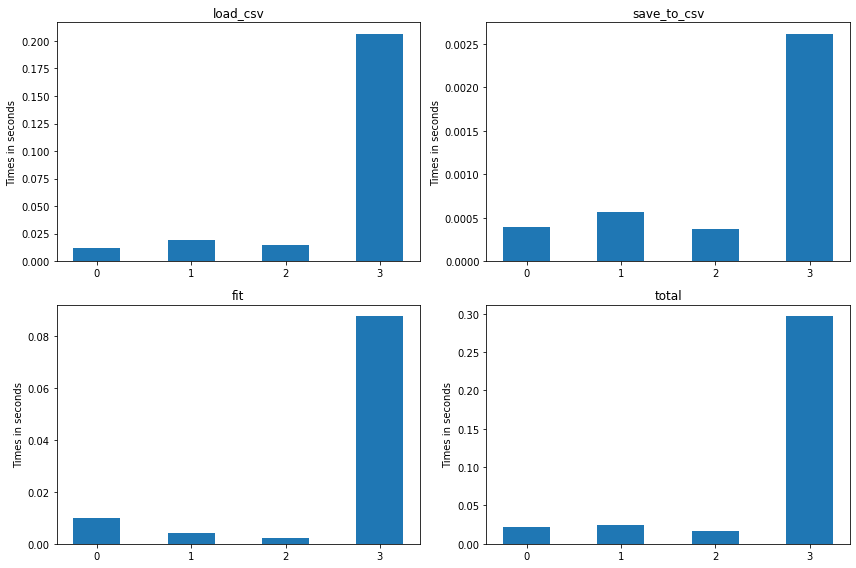

               type  load_csv  save_to_csv       fit
248  cpp_sequential  0.032548     0.001147  0.023062
278    taskflow_cpu  0.054067     0.001244  0.011096
308    cpp_parallel  0.047924     0.001345  0.006851
338  python_sklearn  0.821966     0.001060  0.087698 


Params:
        num_of_samples: 128000
        num_of_features: 8
        num_of_iteartions: 1
        num_of_clusters: 64
    
(0, 'cpp_sequential')
(1, 'taskflow_cpu')
(2, 'cpp_parallel')
(3, 'python_sklearn')


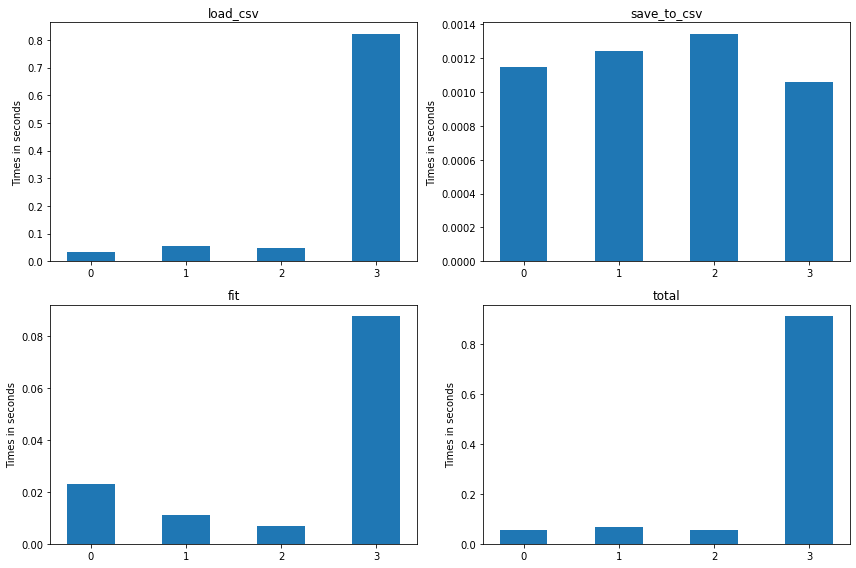

               type  load_csv  save_to_csv       fit
256  cpp_sequential  0.213095     0.008023  0.185489
286    taskflow_cpu  0.287218     0.011267  0.062394
316    cpp_parallel  0.250999     0.007813  0.036517
346  python_sklearn  6.358569     0.000802  0.236046 


Params:
        num_of_samples: 1000000
        num_of_features: 8
        num_of_iteartions: 1
        num_of_clusters: 64
    
(0, 'cpp_sequential')
(1, 'taskflow_cpu')
(2, 'cpp_parallel')
(3, 'python_sklearn')


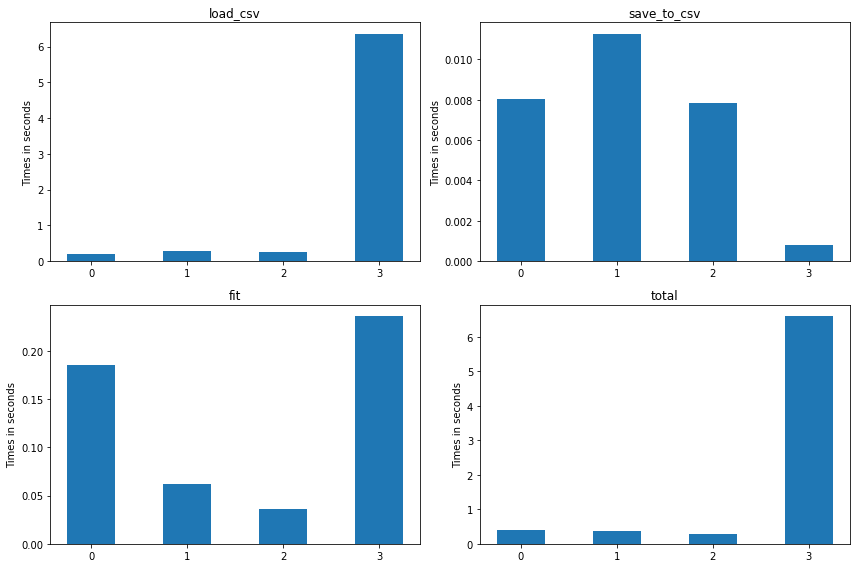

In [16]:

def histogram_parts(bmrk, num_of_samples, num_of_features, num_of_clusters, num_of_iterations):
    bmrk = bmrk.loc[((bmrk['num_of_samples'] == num_of_samples) 
                & (bmrk['num_of_features'] == num_of_features) 
                & (bmrk['num_of_iterations'] == num_of_iterations)
                & (bmrk['num_of_clusters'] == num_of_clusters))]
    if bmrk.empty:
        return
    print(bmrk.loc[:, ['type', 'load_csv', 'save_to_csv', 'fit']], '\n')
    print(f'''
Params:
        num_of_samples: {num_of_samples}
        num_of_features: {num_of_features}
        num_of_iteartions: {num_of_iterations}
        num_of_clusters: {num_of_clusters}
    ''')
    
    labels = bmrk['type'].unique()
    load_times = bmrk['load_csv']
    X = np.arange(len(labels))
    print('\n'.join(map(str, list(zip(X, labels)))))
    width = 0.5
    fig, ax = plt.subplots(2,2, figsize=(12, 8))

    bar = ax[0,0].bar(X, load_times, width, label='load_csv')
    ax[0,0].set_ylabel('Times in seconds')
    ax[0,0].set_title('load_csv')
    ax[0,0].set_xticks(X)
    
    save_times = bmrk['save_to_csv']
    bar = ax[0,1].bar(X, save_times, width, label='save_to_csv')
    ax[0,1].set_ylabel('Times in seconds')
    ax[0,1].set_title('save_to_csv')
    ax[0,1].set_xticks(X)
    
    fit_times = bmrk['fit']
    bar = ax[1,0].bar(X, fit_times, width, label='fit')
    ax[1,0].set_ylabel('Times in seconds')
    ax[1,0].set_title('fit')
    ax[1,0].set_xticks(X)
    
    total = load_times + save_times + fit_times

    bar = ax[1,1].bar(X, total, width, label='total')
    ax[1,1].set_ylabel('Times in seconds')
    ax[1,1].set_title('total')
    ax[1,1].set_xticks(X)
    
    fig.tight_layout()
    plt.show()
    

num_of_features = 8
num_of_clusters = 64
num_of_iterations = 1
for sample_size in sorted(unique_num_of_samples):
    histogram_parts(bmrk, sample_size, num_of_features, num_of_clusters, num_of_iterations)

               type  load_csv  save_to_csv       fit
246  cpp_sequential  0.438030     0.000373  0.740468
276    taskflow_cpu  0.906010     0.000381  0.116255
306    cpp_parallel  0.671074     0.000377  0.070355
336  python_sklearn  5.803740     0.025126  0.182780 


Params:
        num_of_samples: 32000
        num_of_features: 512
        num_of_iteartions: 1
        num_of_clusters: 64
    
(0, 'cpp_sequential')
(1, 'taskflow_cpu')
(2, 'cpp_parallel')
(3, 'python_sklearn')


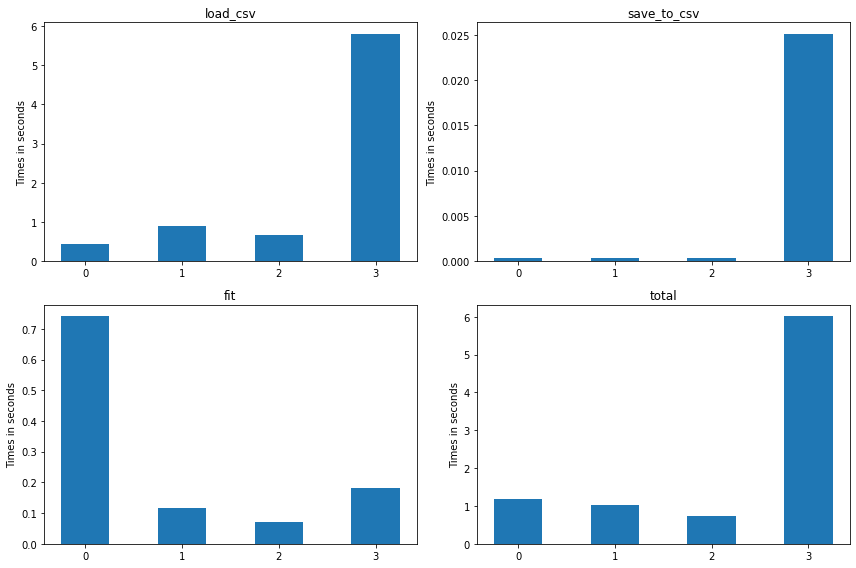

               type   load_csv  save_to_csv       fit
254  cpp_sequential   1.749600     0.001120  2.866973
284    taskflow_cpu   2.107763     0.002291  0.446845
314    cpp_parallel   1.671447     0.001171  0.235411
344  python_sklearn  23.369380     0.020527  0.411303 


Params:
        num_of_samples: 128000
        num_of_features: 512
        num_of_iteartions: 1
        num_of_clusters: 64
    
(0, 'cpp_sequential')
(1, 'taskflow_cpu')
(2, 'cpp_parallel')
(3, 'python_sklearn')


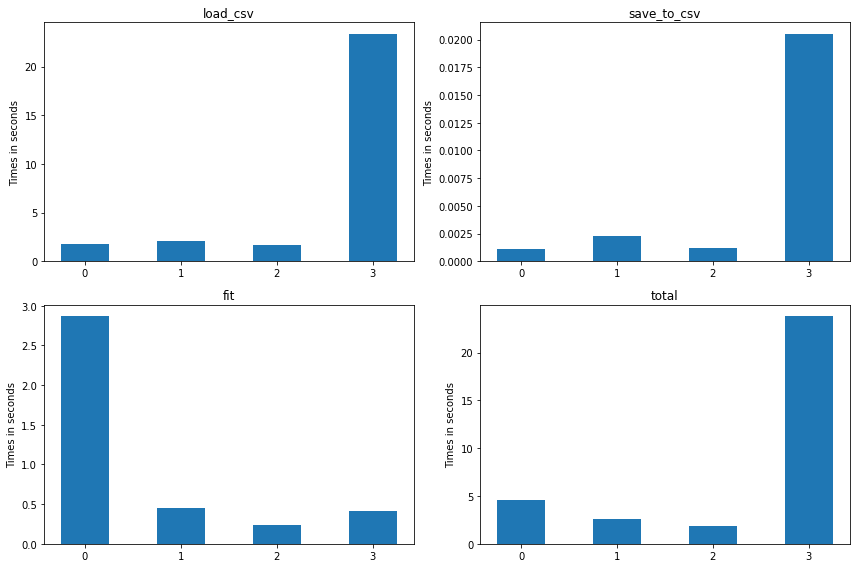

In [14]:
num_of_features = 512
num_of_clusters = 64
num_of_iterations = 1
for sample_size in sorted(unique_num_of_samples):
    histogram_parts(bmrk, sample_size, num_of_features, num_of_clusters, num_of_iterations)

In [9]:
unique_types = bmrk['type'].unique()
for t in unique_types:
    print(t, ' fit total:', bmrk.loc[bmrk['type'] == t]['fit'].sum())

cpp_sequential  fit total: 48.229728808
taskflow_cpu  fit total: 10.04261846
cpp_parallel  fit total: 5.364536943000001
python_sklearn  fit total: 23.050163507461548


In [11]:
for t in unique_types:
    print(t, ' fit total:', bmrk.loc[bmrk['type'] == t]['load_csv'].sum())

cpp_sequential  fit total: 83.455679259
taskflow_cpu  fit total: 87.840001154
cpp_parallel  fit total: 96.60086525400001
python_sklearn  fit total: 1095.5325756072998


In [12]:
for t in unique_types:
    print(t, ' fit total:', bmrk.loc[bmrk['type'] == t]['save_to_csv'].sum())

cpp_sequential  fit total: 0.5101963389999999
taskflow_cpu  fit total: 0.552872668
cpp_parallel  fit total: 0.51711731
python_sklearn  fit total: 0.3501093387603716
